**<span style="color:rgb(247, 169, 0);">[Sana Sabeti]</span> - <span style="color:rgb(143, 95, 195);">[810101398]</span>**

In [9]:
import matplotlib.pyplot as plt
import random
import itertools
import numpy as np

## Part One: Genetic Algorithm👀

In [10]:
num_terms = 20
numCoeffs = 1 + num_terms * 2  # a0 + an + bn
populationSize = 200
generations = 500
mutationRate = 0.1
crossoverRate = 0.9
elitismRate = 0.1
gene_limit = 5
functionRange = (0, 1)
sampleCount = 100
regularization_alpha = 0.0005

In [11]:
# These functions are given as samples to use in the algorithm
def getTargetFunction(functionName="cubic"):
    def sinCosFunction(t):
        """Target function: sin(2πt) + 0.5*cos(4πt)."""
        return np.sin(2 * np.pi * t) + 0.5 * np.cos(4 * np.pi * t)

    def linearFunction(t):
        """Simple linear function: y = 2t + 1."""
        return 2 * t + 1

    def quadraticFunction(t):
        """Quadratic function: y = 4t^2 - 4t + 2."""
        return 4 * (t**2) - 4 * t + 2

    def cubicFunction(t):
        """Cubic function: y = 8t^3 - 12t^2 + 6t."""
        return 8 * (t**3) - 12 * (t**2) + 6 * t

    def gaussianFunction(t):
        """Gaussian function centered at t=0.5."""
        mu = 0.5
        sigma = 0.1  # Adjust sigma to control the width of the peak
        return np.exp(-((t - mu) ** 2) / (2 * sigma**2))

    def squareWaveFunction(t):
        """Approximation of a square wave. Smoothed for better Fourier approximation."""
        return 0.5 * (np.sign(np.sin(2 * np.pi * t)) + 1)

    def sawtoothFunction(t):
        """Sawtooth wave, normalized to [0, 1]."""
        return (t * 5) % 1

    def complexFourierFunction(t):
        return (
            np.sin(2 * np.pi * t)
            + 0.3 * np.cos(4 * np.pi * t)
            + 0.2 * np.sin(6 * np.pi * t)
            + 0.1 * np.cos(8 * np.pi * t)
        )

    def polynomialFunction(t):
        return 10 * (t**5) - 20 * (t**4) + 15 * (t**3) - 4 * (t**2) + t + 0.5

    functionOptions = {
        "sin_cos": sinCosFunction,
        "linear": linearFunction,
        "quadratic": quadraticFunction,
        "cubic": cubicFunction,
        "gaussian": gaussianFunction,
        "square_wave": squareWaveFunction,
        "sawtooth": sawtoothFunction,
        "complex_fourier": complexFourierFunction,
        "polynomial": polynomialFunction,
    }

    selectedFunction = functionOptions.get(functionName.lower())
    if selectedFunction:
        return selectedFunction

In [12]:
# generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction()(tSamples)

##  Part One: Definition of Concepts

In this problem, our goal is to approximate an unknown function using the **Fourier Series**. To do this, we employ a Genetic Algorithm to find the best coefficients of the Fourier expansion.

### Definition of a Gene
Each **gene** in this problem represents a coefficient in the Fourier Series. Since we are using \( N = 20 \) terms, the gene structure is as follows:

- One \( a_0 \) coefficient (the constant term)
- Thirty \( a_n \) coefficients for \( n = 1 \) to \( 20 \)
- Thirty \( b_n \) coefficients for \( n = 1 \) to \( 20 \)

In total:
\[
\text{Number of Genes} = 1 + 20 + 20 = 41
\]

### Definition of a Chromosome
A **chromosome** represents a complete candidate solution. It is a list of 41 real-valued numbers representing the Fourier coefficients:
\[
\text{Chromosome} = [a_0, a_1, ..., a_{20}, b_1, ..., b_{20}]
\]

Each chromosome defines a specific Fourier series approximation of the target function.



__________________________________________________________________________________________________________________________________________________________________________________

## Part Two: Creating the Initial Population

At the start of the algorithm, we need to create an **initial population** of chromosomes. Each chromosome is a potential solution, represented as a set of Fourier series coefficients.

###  Importance of Population
The initial population plays a critical role in:
- Ensuring **diversity** in the solution space
- Providing a broad search base to avoid premature convergence
- Increasing the chances of finding near-optimal or optimal solutions

Each chromosome in the population is generated by randomly sampling 61 coefficients (genes) within a specified range, for example \([-5, 5]\).

###  Parameter Choice: Population Size
The **population size** is a user-defined parameter that directly affects:
- The **diversity** of the initial generation
- The **speed** and **quality** of convergence

Larger populations generally offer better diversity but require more computation per generation.

###  Suggested Analysis
As part of the analysis, you should run the genetic algorithm with **at least three different population sizes** (e.g., 50, 100, 200), and compare the evolution of the best fitness over generations.

This can be visualized in a plot where:
- The x-axis represents the number of generations
- The y-axis represents the best fitness value in each generation

From this comparison, you can draw conclusions about how population size impacts the algorithm's performance and convergence behavior.


In [13]:
num_terms = 20
numCoeffs = 1 + num_terms * 2 
populationSize = 200
generations = 500
gene_limit = 10 #A
def create_random_chromosome():
    return [random.uniform(-gene_limit, gene_limit) for _ in range(numCoeffs)]

def initialize_population():
    return [create_random_chromosome() for _ in range(populationSize)]

__________________________________________________________________________________________________________________________________________________________________________________

##  Part Three: Compatibility Measurement Criteria

To evaluate how well each chromosome (i.e., a set of Fourier coefficients) approximates the target function, we must define a **fitness function**, which measures the "compatibility" or "goodness" of each solution.

###  Objective

The fitness function quantifies the **difference** between the target function and the function reconstructed using the Fourier coefficients of a chromosome. The smaller the difference, the better the chromosome.



###  Common Error Metrics

Below are four commonly used criteria for measuring approximation error:

1. **MSE (Mean Squared Error)**  
   This metric computes the average of the squared differences between the predicted values and the true values:

   $$
   \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( f_{\text{pred}}(t_i) - f_{\text{true}}(t_i) \right)^2
   $$

   - Simple and widely used in regression and approximation problems.
   - Sensitive to large errors.
   - Used directly in the fitness function of our implementation.

2. **RMSE (Root Mean Square Error)**  
   RMSE is the square root of MSE and represents the error in the same units as the output:

   $$
   \text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} \left( f_{\text{pred}}(t_i) - f_{\text{true}}(t_i) \right)^2 }
   $$

   - Easier to interpret than MSE because it's on the same scale as the data.
   - Also sensitive to large deviations.

3. **MAE (Mean Absolute Error)**  
   MAE measures the average magnitude of the errors in a set of predictions:

   $$
   \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| f_{\text{pred}}(t_i) - f_{\text{true}}(t_i) \right|
   $$

   - Less sensitive to outliers than MSE and RMSE.
   - Gives a linear penalty to all deviations.

4. **R² Score (Coefficient of Determination)**  
   R² explains how much of the variance in the actual data is captured by the model:

   $$
   R^2 = 1 - \frac{ \sum_{i=1}^{n} \left( f_{\text{true}}(t_i) - f_{\text{pred}}(t_i) \right)^2 }{ \sum_{i=1}^{n} \left( f_{\text{true}}(t_i) - \bar{f}_{\text{true}} \right)^2 }
   $$

   - Ranges from \(-\infty\) to 1.
   - Closer to 1 means a better fit.


###  Final Fitness Function Used

We used a **regularized Mean Squared Error (MSE)** as the fitness function. This function not only measures how well the Fourier series fits the target function but also penalizes large coefficients to prevent overfitting.

The fitness function is defined as:

$$
\text{Fitness} = - \left( \frac{1}{n} \sum_{i=1}^{n} \left( f_{\text{pred}}(t_i) - f_{\text{true}}(t_i) \right)^2 + \alpha \cdot \frac{1}{k} \sum_{j=1}^{k} \text{coeff}_j^2 \right)
$$

Where:
- \( n \) is the number of sampled points.
- \( k \) is the total number of coefficients (genes in the chromosome).
- \( \alpha \) is the regularization coefficient (`regularization_alpha = 0.0005` in the code).
- The first term is the **Mean Squared Error (MSE)**.
- The second term is an **L2 regularization** that penalizes large coefficients.
- The **negative sign** is used because the Genetic Algorithm maximizes fitness, while we want to **minimize the error**.

> **Note:** We use **MSE** rather than **RMSE**, which means we do not take the square root of the error term.



In [14]:
regularization_alpha = 0.0005
def evaluate_fourier_series(chromosome, t):
    a0 = chromosome[0]
    an = chromosome[1 : 1 + num_terms]
    bn = chromosome[1 + num_terms :]

    result = a0
    for n in range(1, num_terms + 1):
        result += an[n - 1] * np.cos(2 * np.pi * n * t)
        result += bn[n - 1] * np.sin(2 * np.pi * n * t)
    return result

def fitness_regularized(chromosome, t, y_true, alpha=regularization_alpha):
    y_pred = evaluate_fourier_series(chromosome, t)
    error = np.mean((y_pred - y_true) ** 2)
    regularization = np.mean(np.square(chromosome))
    return -(error + alpha * regularization)

def fitness_rmse_regularized(chromosome, t, y_true, alpha=regularization_alpha):
    y_pred = evaluate_fourier_series(chromosome, t)
    
    # RMSE: Root Mean Squared Error
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
    # L2 Regularization: average of squared coefficients
    regularization = np.mean(np.square(chromosome))
    
    # Negative because the GA maximizes fitness (we want to minimize error)
    return -(rmse + alpha * regularization)

__________________________________________________________________________________________________________________________________________________________________________________

##  Part Four: Crossover, Mutation, and Next Generation Selection Strategy

To move toward better solutions across generations, the Genetic Algorithm uses two key genetic operations: **crossover** and **mutation**, along with a selection strategy to build each new population.


###  Crossover (Recombination)

The **crossover operator** combines two parent chromosomes to produce new offspring. The idea is to inherit useful traits from both parents in hopes of forming better solutions.

Two types of crossover used in this implementation:

1. **Uniform Crossover**  
   Each gene in the offspring is selected randomly from one of the two parents with equal probability. This promotes **high diversity**.
   
2. **Single-Point Crossover**  
   A random crossover point is selected. Genes before the point are taken from one parent, and the rest from the other. This keeps **more structure** from each parent.

> **Crossover Rate** (e.g., 0.9) determines the probability that crossover is applied between two selected parents.



###  Mutation

The **mutation operator** randomly perturbs individual genes in a chromosome. It allows exploration of new areas in the search space and helps avoid premature convergence.

- In this implementation, each gene has a small probability (e.g., 0.1) of being mutated by adding a small Gaussian noise.
- The **mutation intensity decreases over generations**, encouraging exploration early and fine-tuning later.

> Mutated genes are always clipped within the allowed gene range (e.g., \([-5, 5]\)).



###  Elitism

To ensure the best solutions are preserved, a fixed percentage (e.g., 10%) of the **top-performing chromosomes** from each generation are **carried over directly** to the next generation.

This helps maintain the **best-found solutions** and accelerates convergence.



###  Selection Strategies

Two selection strategies are used to choose parents for reproduction:

- **Tournament Selection**: Randomly selects a few individuals and chooses the best among them.
- **Roulette Wheel Selection**: Selects individuals probabilistically based on their fitness score.

Each strategy has its own advantages in terms of **diversity** and **selection pressure**, and is analyzed in the results section.


In [15]:
mutationRate = 0.1
crossoverRate = 0.9
elitismRate = 0.1

# ---------- Crossover Methods ----------
def uniform_crossover(parent1, parent2):
    if random.random() < crossoverRate:
        child1, child2 = [], []
        for i in range(numCoeffs):
            if random.random() < 0.5:
                child1.append(parent1[i])
                child2.append(parent2[i])
            else:
                child1.append(parent2[i])
                child2.append(parent1[i])
        return child1, child2
    else:
        return parent1[:], parent2[:]

def single_point_crossover(parent1, parent2):
    if random.random() < crossoverRate:
        point = random.randint(1, numCoeffs - 1)
        return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]
    else:
        return parent1[:], parent2[:]
    
    # ---------- Mutation ----------
def mutation(chromosome, current_generation):
    scale = max(0.1, 1.0 - (current_generation / generations))
    for i in range(len(chromosome)):
        if random.random() < mutationRate:
            chromosome[i] += random.gauss(0, 0.3 * scale)
            chromosome[i] = np.clip(chromosome[i], -gene_limit, gene_limit)
    return chromosome
    
    # ---------- Selection Methods ----------
def tournament_selection(population, fitness_values, k=3):
    selected = random.sample(list(zip(population, fitness_values)), k)
    return max(selected, key=lambda x: x[1])[0]

def roulette_selection(population, fitness_values):
    fitness_shifted = [f - min(fitness_values) + 1e-6 for f in fitness_values]
    total = sum(fitness_shifted)
    probabilities = [f / total for f in fitness_shifted]
    return population[np.random.choice(len(population), p=probabilities)]
    


To evaluate the effectiveness of different strategies in our genetic algorithm, we tested and compared **four combinations** of selection and crossover methods:

1. **Tournament + Uniform**
2. **Tournament + Single Point**
3. **Roulette + Uniform**
4. **Roulette + Single Point**

The figure below shows the trend of **best fitness values** over 300 generations for each combination:
![alt text](image.png)


###  Method Comparison

#### 1. **Tournament + Uniform (Blue Line)**
- **Best performing strategy overall**
- Fastest convergence to optimal fitness
- Combines the strength of tournament selection (strong selection pressure) with uniform crossover (high genetic diversity)

#### 2. **Tournament + Single Point (Orange Line)**
- Performs well, but slightly slower than uniform crossover
- Single-point crossover reduces diversity compared to uniform crossover, which may slow down convergence

#### 3. **Roulette + Uniform (Green Line)**
- Moderate performance
- Roulette selection introduces randomness, which may allow weaker individuals to be selected, slowing down the learning process
- Uniform crossover helps maintain diversity

#### 4. **Roulette + Single Point (Red Line)**
- **Worst performance**
- Roulette selection combined with low-diversity crossover results in slow convergence and less optimal fitness


###  Conclusion

Based on the graph, **Tournament Selection + Uniform Crossover** is clearly the best strategy in terms of convergence speed and final accuracy. Therefore, **we will use this configuration in future experiments and implementations**.

__________________________________________________________________________________________________________________________________________________________________________________

##  Part Five: Offspring Analysis

To evaluate the accuracy and effectiveness of our Genetic Algorithm, we use two main visual tools:


###  1. Fitness Curve Over Generations

We plot the **best fitness value** in each generation for different combinations of selection and crossover strategies. This allows us to:

- Observe the **convergence speed** of each method
- Identify which strategies lead to **better approximations**
- Monitor for **premature convergence** or stagnation

In our experiments, we compared the following four strategies:
- Tournament + Uniform
- Tournament + Single Point
- Roulette + Uniform
- Roulette + Single Point

> Refer to the fitness plot above for detailed performance comparison.


###  2. Function Approximation vs. Ground Truth

For visual verification, we plot:
- The **original target function**
- The **Fourier approximation** obtained from the best chromosome at the final generation

This helps us:
- Visually assess how closely the Fourier series fits the true function
- Detect any **bias** or **underfitting/overfitting**
- Validate the real-world performance of the selected strategy

It is recommended to repeat this visualization for multiple different target functions (e.g., `sin_cos`, `polynomial`, `square_wave`, etc.) to evaluate the generalization ability of the algorithm.


###  Summary

Combining the fitness curves and function approximation plots provides a comprehensive view of the algorithm's correctness and effectiveness across different settings.


Generation 1: Best Fitness = -388.169656
Generation 2: Best Fitness = -388.169656
Generation 3: Best Fitness = -388.169656
Generation 4: Best Fitness = -388.169656
Generation 5: Best Fitness = -386.778885
Generation 6: Best Fitness = -363.416066
Generation 7: Best Fitness = -363.149407
Generation 8: Best Fitness = -359.913196
Generation 9: Best Fitness = -349.969421
Generation 10: Best Fitness = -322.079625
Generation 11: Best Fitness = -300.657610
Generation 12: Best Fitness = -300.657610
Generation 13: Best Fitness = -259.804127
Generation 14: Best Fitness = -259.804127
Generation 15: Best Fitness = -220.594339
Generation 16: Best Fitness = -220.594339
Generation 17: Best Fitness = -220.594339
Generation 18: Best Fitness = -220.594339
Generation 19: Best Fitness = -212.462506
Generation 20: Best Fitness = -212.462506
Generation 21: Best Fitness = -179.843294
Generation 22: Best Fitness = -152.609630
Generation 23: Best Fitness = -152.609630
Generation 24: Best Fitness = -152.609630
G

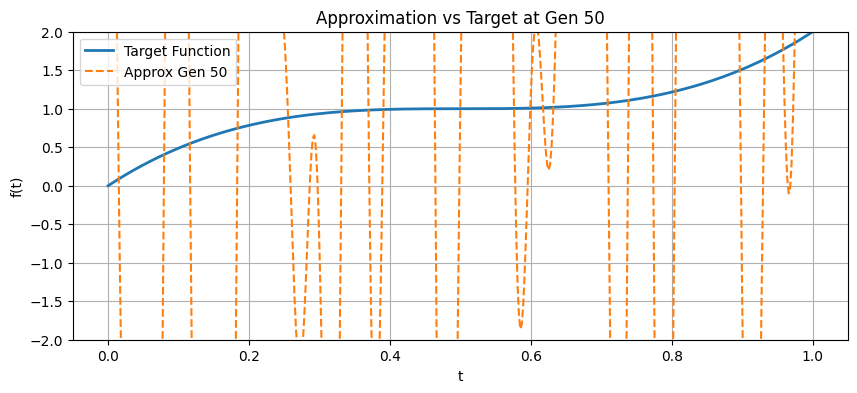

Generation 51: Best Fitness = -54.275455
Generation 52: Best Fitness = -49.091543
Generation 53: Best Fitness = -49.091543
Generation 54: Best Fitness = -49.091543
Generation 55: Best Fitness = -46.267223
Generation 56: Best Fitness = -45.316762
Generation 57: Best Fitness = -43.856646
Generation 58: Best Fitness = -43.002140
Generation 59: Best Fitness = -41.420015
Generation 60: Best Fitness = -41.420015
Generation 61: Best Fitness = -40.902831
Generation 62: Best Fitness = -37.346706
Generation 63: Best Fitness = -35.033332
Generation 64: Best Fitness = -30.677596
Generation 65: Best Fitness = -30.677596
Generation 66: Best Fitness = -30.677596
Generation 67: Best Fitness = -28.152516
Generation 68: Best Fitness = -25.932449
Generation 69: Best Fitness = -25.932449
Generation 70: Best Fitness = -25.932449
Generation 71: Best Fitness = -25.932449
Generation 72: Best Fitness = -24.401358
Generation 73: Best Fitness = -21.698433
Generation 74: Best Fitness = -21.698433
Generation 75: B

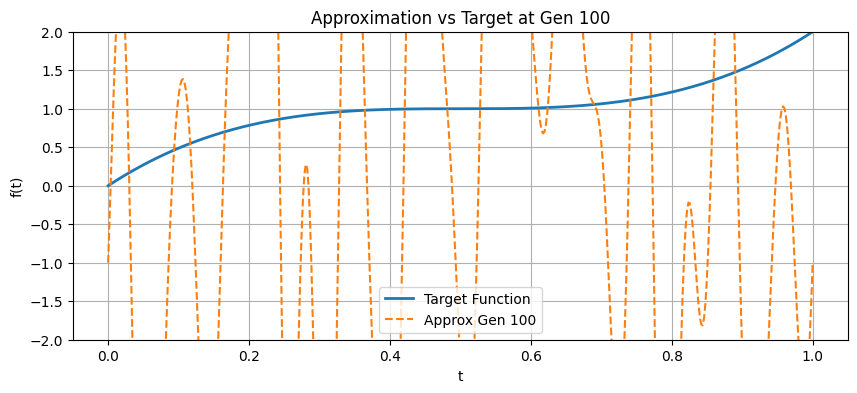

Generation 101: Best Fitness = -11.901638
Generation 102: Best Fitness = -9.788976
Generation 103: Best Fitness = -9.788976
Generation 104: Best Fitness = -9.788976
Generation 105: Best Fitness = -9.788976
Generation 106: Best Fitness = -9.788976
Generation 107: Best Fitness = -8.760209
Generation 108: Best Fitness = -8.760209
Generation 109: Best Fitness = -8.760209
Generation 110: Best Fitness = -8.527118
Generation 111: Best Fitness = -7.885049
Generation 112: Best Fitness = -7.885049
Generation 113: Best Fitness = -7.885049
Generation 114: Best Fitness = -7.848273
Generation 115: Best Fitness = -7.255563
Generation 116: Best Fitness = -7.255563
Generation 117: Best Fitness = -7.255563
Generation 118: Best Fitness = -6.763657
Generation 119: Best Fitness = -6.522496
Generation 120: Best Fitness = -6.387597
Generation 121: Best Fitness = -6.387597
Generation 122: Best Fitness = -6.387597
Generation 123: Best Fitness = -5.972674
Generation 124: Best Fitness = -5.662504
Generation 125:

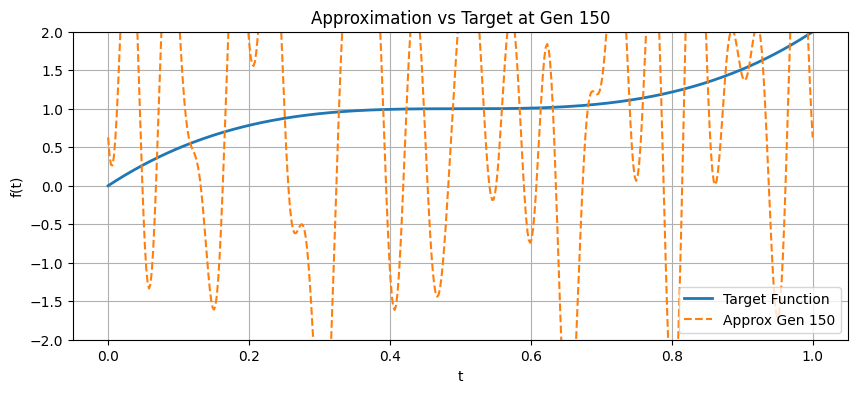

Generation 151: Best Fitness = -2.003007
Generation 152: Best Fitness = -1.537480
Generation 153: Best Fitness = -1.450977
Generation 154: Best Fitness = -1.450977
Generation 155: Best Fitness = -1.450977
Generation 156: Best Fitness = -1.334626
Generation 157: Best Fitness = -1.334626
Generation 158: Best Fitness = -1.334626
Generation 159: Best Fitness = -1.212929
Generation 160: Best Fitness = -1.212929
Generation 161: Best Fitness = -1.212929
Generation 162: Best Fitness = -1.049198
Generation 163: Best Fitness = -1.049198
Generation 164: Best Fitness = -1.037106
Generation 165: Best Fitness = -1.037106
Generation 166: Best Fitness = -1.037106
Generation 167: Best Fitness = -0.951757
Generation 168: Best Fitness = -0.951757
Generation 169: Best Fitness = -0.951757
Generation 170: Best Fitness = -0.951757
Generation 171: Best Fitness = -0.938446
Generation 172: Best Fitness = -0.938446
Generation 173: Best Fitness = -0.938446
Generation 174: Best Fitness = -0.817147
Generation 175: 

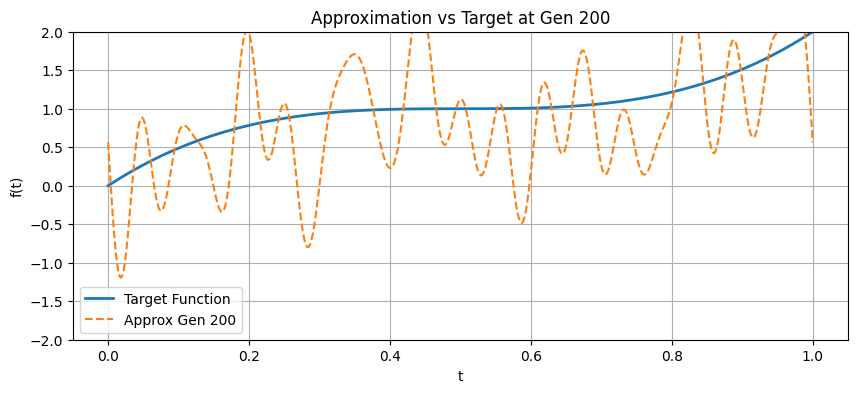

Generation 201: Best Fitness = -0.453546
Generation 202: Best Fitness = -0.453546
Generation 203: Best Fitness = -0.453546
Generation 204: Best Fitness = -0.453546
Generation 205: Best Fitness = -0.453546
Generation 206: Best Fitness = -0.453546
Generation 207: Best Fitness = -0.453546
Generation 208: Best Fitness = -0.453546
Generation 209: Best Fitness = -0.453546
Generation 210: Best Fitness = -0.453546
Generation 211: Best Fitness = -0.453546
Generation 212: Best Fitness = -0.453546
Generation 213: Best Fitness = -0.453546
Generation 214: Best Fitness = -0.453546
Generation 215: Best Fitness = -0.433468
Generation 216: Best Fitness = -0.433468
Generation 217: Best Fitness = -0.433468
Generation 218: Best Fitness = -0.428246
Generation 219: Best Fitness = -0.428246
Generation 220: Best Fitness = -0.408571
Generation 221: Best Fitness = -0.408571
Generation 222: Best Fitness = -0.408571
Generation 223: Best Fitness = -0.374702
Generation 224: Best Fitness = -0.374702
Generation 225: 

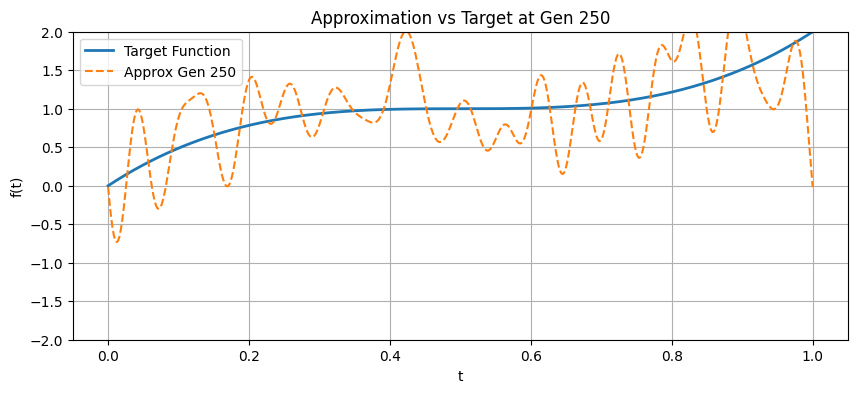

Generation 251: Best Fitness = -0.250510
Generation 252: Best Fitness = -0.250510
Generation 253: Best Fitness = -0.250510
Generation 254: Best Fitness = -0.248245
Generation 255: Best Fitness = -0.221203
Generation 256: Best Fitness = -0.221203
Generation 257: Best Fitness = -0.221203
Generation 258: Best Fitness = -0.221203
Generation 259: Best Fitness = -0.221203
Generation 260: Best Fitness = -0.221203
Generation 261: Best Fitness = -0.221203
Generation 262: Best Fitness = -0.189209
Generation 263: Best Fitness = -0.189209
Generation 264: Best Fitness = -0.189209
Generation 265: Best Fitness = -0.189209
Generation 266: Best Fitness = -0.189209
Generation 267: Best Fitness = -0.189209
Generation 268: Best Fitness = -0.189209
Generation 269: Best Fitness = -0.189209
Generation 270: Best Fitness = -0.189209
Generation 271: Best Fitness = -0.189209
Generation 272: Best Fitness = -0.189209
Generation 273: Best Fitness = -0.189209
Generation 274: Best Fitness = -0.189209
Generation 275: 

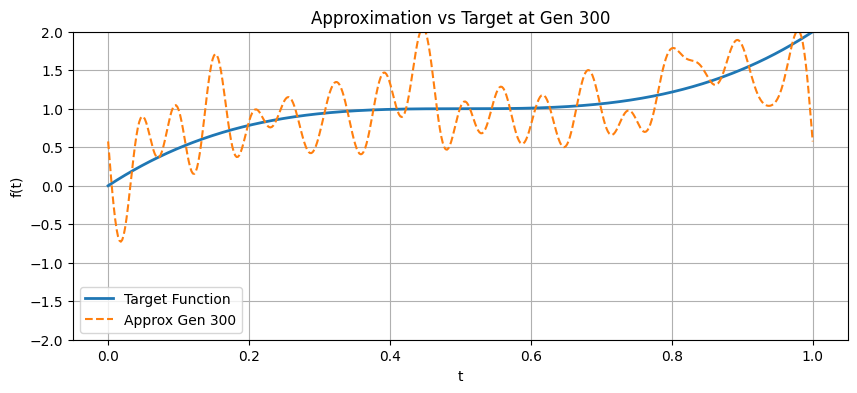

Generation 301: Best Fitness = -0.164815
Generation 302: Best Fitness = -0.147905
Generation 303: Best Fitness = -0.147905
Generation 304: Best Fitness = -0.136907
Generation 305: Best Fitness = -0.136907
Generation 306: Best Fitness = -0.136907
Generation 307: Best Fitness = -0.136907
Generation 308: Best Fitness = -0.136907
Generation 309: Best Fitness = -0.136907
Generation 310: Best Fitness = -0.124726
Generation 311: Best Fitness = -0.124726
Generation 312: Best Fitness = -0.124726
Generation 313: Best Fitness = -0.124726
Generation 314: Best Fitness = -0.124726
Generation 315: Best Fitness = -0.124726
Generation 316: Best Fitness = -0.124726
Generation 317: Best Fitness = -0.124726
Generation 318: Best Fitness = -0.124726
Generation 319: Best Fitness = -0.124726
Generation 320: Best Fitness = -0.124726
Generation 321: Best Fitness = -0.124726
Generation 322: Best Fitness = -0.124726
Generation 323: Best Fitness = -0.124726
Generation 324: Best Fitness = -0.118902
Generation 325: 

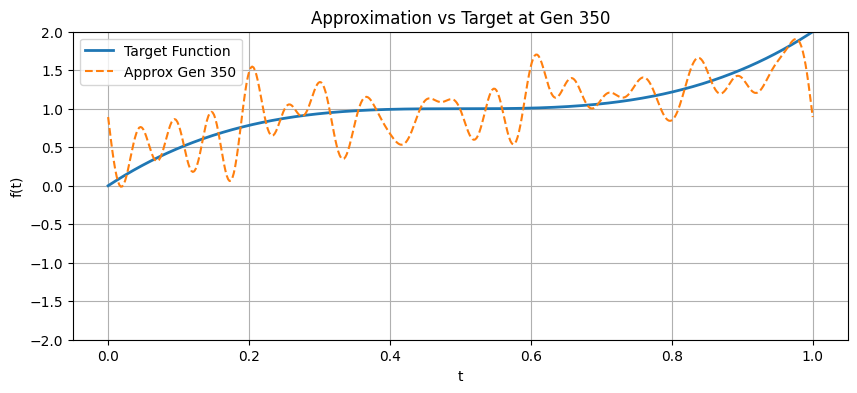

Generation 351: Best Fitness = -0.097140
Generation 352: Best Fitness = -0.092266
Generation 353: Best Fitness = -0.092266
Generation 354: Best Fitness = -0.092266
Generation 355: Best Fitness = -0.091830
Generation 356: Best Fitness = -0.091830
Generation 357: Best Fitness = -0.083996
Generation 358: Best Fitness = -0.083996
Generation 359: Best Fitness = -0.083996
Generation 360: Best Fitness = -0.083996
Generation 361: Best Fitness = -0.083996
Generation 362: Best Fitness = -0.083996
Generation 363: Best Fitness = -0.083996
Generation 364: Best Fitness = -0.083996
Generation 365: Best Fitness = -0.083996
Generation 366: Best Fitness = -0.083996
Generation 367: Best Fitness = -0.083996
Generation 368: Best Fitness = -0.083996
Generation 369: Best Fitness = -0.083996
Generation 370: Best Fitness = -0.083996
Generation 371: Best Fitness = -0.083996
Generation 372: Best Fitness = -0.083996
Generation 373: Best Fitness = -0.083996
Generation 374: Best Fitness = -0.083996
Generation 375: 

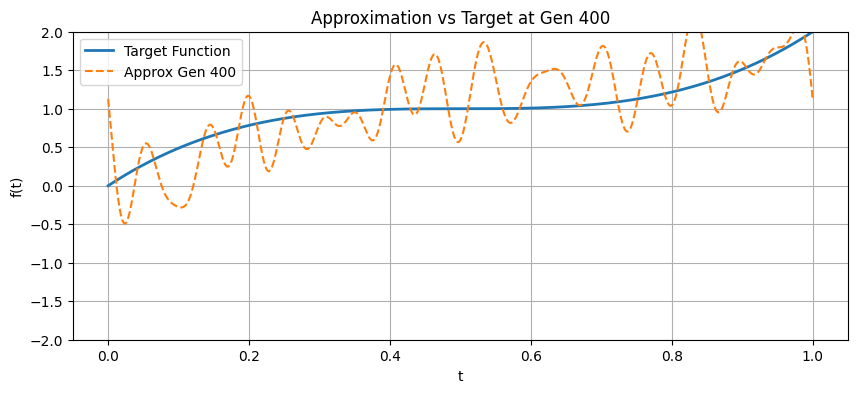

Generation 401: Best Fitness = -0.058365
Generation 402: Best Fitness = -0.058365
Generation 403: Best Fitness = -0.058365
Generation 404: Best Fitness = -0.058319
Generation 405: Best Fitness = -0.058319
Generation 406: Best Fitness = -0.058319
Generation 407: Best Fitness = -0.058319
Generation 408: Best Fitness = -0.058319
Generation 409: Best Fitness = -0.058319
Generation 410: Best Fitness = -0.058319
Generation 411: Best Fitness = -0.056436
Generation 412: Best Fitness = -0.056436
Generation 413: Best Fitness = -0.056436
Generation 414: Best Fitness = -0.056436
Generation 415: Best Fitness = -0.056436
Generation 416: Best Fitness = -0.056436
Generation 417: Best Fitness = -0.056436
Generation 418: Best Fitness = -0.051932
Generation 419: Best Fitness = -0.051932
Generation 420: Best Fitness = -0.051932
Generation 421: Best Fitness = -0.051932
Generation 422: Best Fitness = -0.048922
Generation 423: Best Fitness = -0.048922
Generation 424: Best Fitness = -0.048922
Generation 425: 

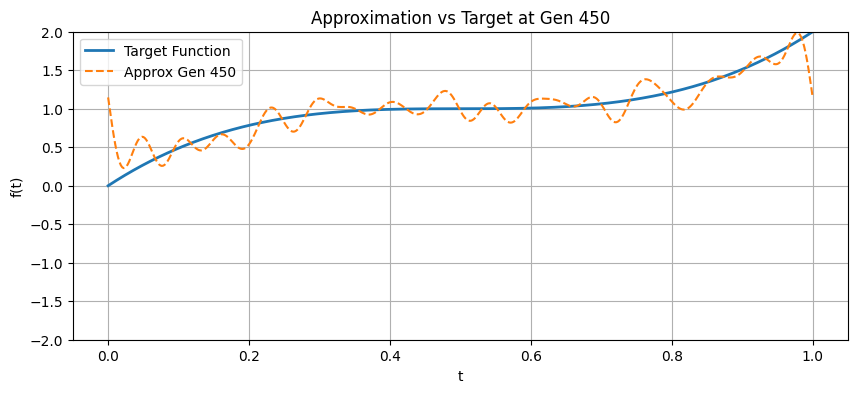

Generation 451: Best Fitness = -0.039209
Generation 452: Best Fitness = -0.038124
Generation 453: Best Fitness = -0.038124
Generation 454: Best Fitness = -0.038124
Generation 455: Best Fitness = -0.038124
Generation 456: Best Fitness = -0.038124
Generation 457: Best Fitness = -0.038124
Generation 458: Best Fitness = -0.037292
Generation 459: Best Fitness = -0.037292
Generation 460: Best Fitness = -0.036166
Generation 461: Best Fitness = -0.036166
Generation 462: Best Fitness = -0.036166
Generation 463: Best Fitness = -0.033635
Generation 464: Best Fitness = -0.033635
Generation 465: Best Fitness = -0.033635
Generation 466: Best Fitness = -0.033635
Generation 467: Best Fitness = -0.033635
Generation 468: Best Fitness = -0.033635
Generation 469: Best Fitness = -0.033635
Generation 470: Best Fitness = -0.033635
Generation 471: Best Fitness = -0.033635
Generation 472: Best Fitness = -0.033379
Generation 473: Best Fitness = -0.033379
Generation 474: Best Fitness = -0.033220
Generation 475: 

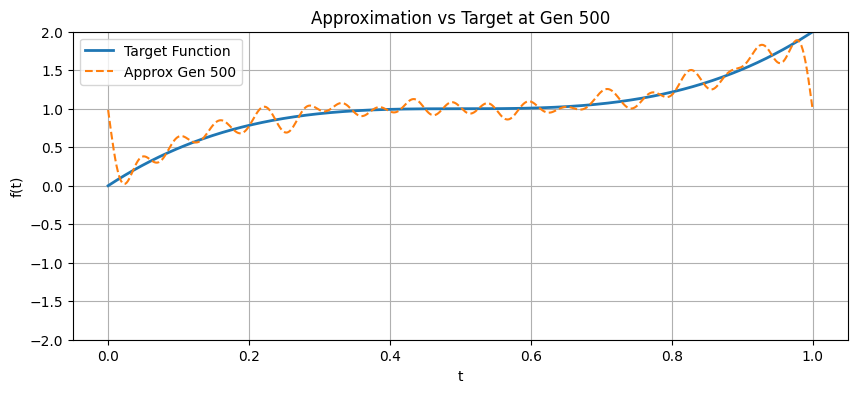

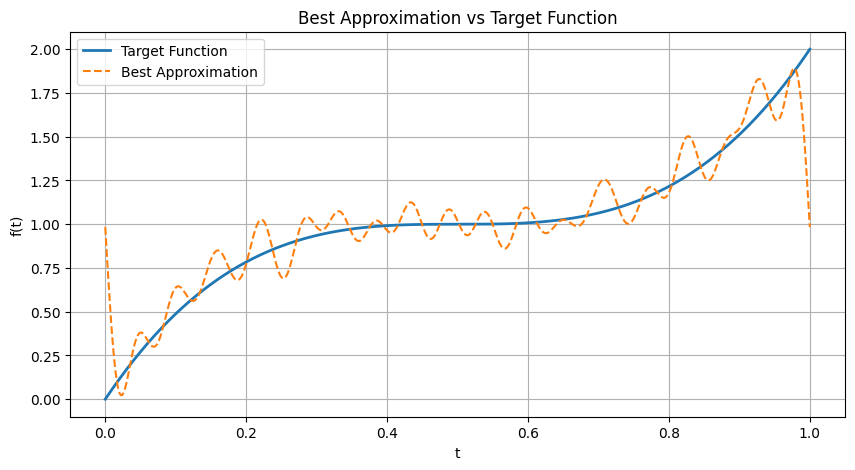

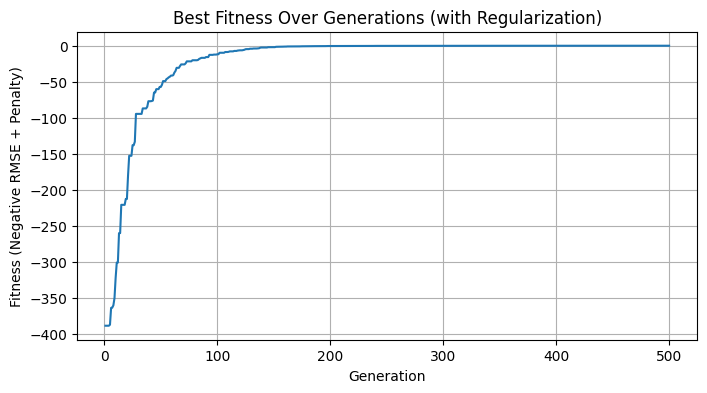

In [16]:
def select_next_generation(population, fitness_values, current_generation):
    num_elites = int(elitismRate * len(population))
    elites = [population[i] for i in np.argsort(fitness_values)[-num_elites:]]

    new_population = elites.copy()
    while len(new_population) < populationSize:
        parent1, parent2 = random.choices(population, k=2)
        child1, child2 = uniform_crossover(parent1, parent2)
        new_population.append(mutation(child1, current_generation))
        if len(new_population) < populationSize:
            new_population.append(mutation(child2, current_generation))
    return new_population

def run_genetic_algorithm():
    population = initialize_population()
    best_fitnesses = []

    for generation in range(generations):
        fitness_values = [fitness_regularized(chromo, tSamples, fSamples) for chromo in population]
        best_fitness = max(fitness_values)
        best_fitnesses.append(best_fitness)

        print(f"Generation {generation + 1}: Best Fitness = {best_fitness:.6f}")
        population = select_next_generation(population, fitness_values, generation)

        if (generation + 1) % 50 == 0:
            best_index = np.argmax(fitness_values)
            best_chromosome = population[best_index]
            t_fine = np.linspace(0, 1, 500)
            y_true = getTargetFunction()(t_fine)
            y_pred = evaluate_fourier_series(best_chromosome, t_fine)

            plt.figure(figsize=(10, 4))
            plt.plot(t_fine, y_true, label="Target Function", linewidth=2)
            plt.plot(t_fine, y_pred, label=f"Approx Gen {generation + 1}", linestyle='--')
            plt.title(f"Approximation vs Target at Gen {generation + 1}")
            plt.xlabel("t")
            plt.ylabel("f(t)")
            plt.ylim(-2, 2)
            plt.legend()
            plt.grid(True)
            plt.show()

    return population, best_fitnesses

final_population, fitness_history = run_genetic_algorithm()

def get_best_chromosome(population):
    fitness_values = [fitness_regularized(chromo, tSamples, fSamples) for chromo in population]
    return population[np.argmax(fitness_values)]

best_chromosome = get_best_chromosome(final_population)

t_fine = np.linspace(0, 1, 500)
y_true = getTargetFunction()(t_fine)
y_pred = evaluate_fourier_series(best_chromosome, t_fine)

plt.figure(figsize=(10, 5))
plt.plot(t_fine, y_true, label="Target Function", linewidth=2)
plt.plot(t_fine, y_pred, label="Best Approximation", linestyle='--')
plt.title("Best Approximation vs Target Function")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 4))
plt.plot(range(1, generations + 1), fitness_history)
plt.title("Best Fitness Over Generations (with Regularization)")
plt.xlabel("Generation")
plt.ylabel("Fitness (Negative RMSE + Penalty)")
plt.grid(True)
plt.show()

## QUESTIONS:⁉️

## 1.  State Space Calculation for Chromosomes with 41 Genes

To understand the scale of the optimization problem, we calculate the total number of possible chromosomes, also known as the **state space size**.

###  Given:
- Number of genes per chromosome:  
  \( n = 41 \)
- Each gene (Fourier coefficient) can take values in the range:  
  \( [-A, A] = [-5, 5] \)
- Precision: 4 decimal places (i.e., step size = 0.0001)


###  Step 1: Possible values per gene

Each gene can take values from \(-5\) to \(+5\) with a step size of 0.0001:

$
\text{Values per gene} = \frac{5 - (-5)}{0.0001} = \frac{10}{0.0001} = 100{,}000
$

###  Step 2: Total number of unique chromosomes

Each chromosome has 41 genes, and each gene has 100,000 possible values:

$
\text{State Space Size} = (100{,}000)^{41} = 10^{5 \times 41} = 10^{205}
$


###  Final Answer:

$
\boxed{\text{State Space Size} \approx 10^{205}}
$

This incredibly large number highlights the necessity of using **heuristic optimization algorithms** like the Genetic Algorithm, as brute-force search is computationally infeasible.


---

## 2. Ideas to Accelerate Convergence of the Genetic Algorithm

Given the enormous size of the search space (~ \( 10^{205} \)), improving the **convergence speed** of the Genetic Algorithm (GA) is crucial for solving the problem more efficiently.

Here are **two practical and effective ideas** that can help the algorithm converge faster:


###  Idea 1: Use Adaptive Mutation Rate

Instead of using a fixed mutation rate throughout all generations, we can use an **adaptive mutation rate** that changes over time.

###  Strategy:
- Start with a **higher mutation rate** in the early generations (e.g., 0.2 or 0.3)
- Gradually **decrease** it as the generations progress (e.g., down to 0.05 or less)

####  Why it helps:
- High mutation early on encourages **exploration** of the search space
- Low mutation later improves **exploitation** and fine-tuning near optimal solutions
- Helps avoid **premature convergence** to local optima


###  Idea 2: Use Hybrid Selection (Elitism + Tournament)

Instead of relying solely on one selection method, a **hybrid approach** can be used that combines the strengths of different strategies.

####  Strategy:
- Preserve the **top x%** of best individuals directly (elitism)
- For the remaining population, use **tournament selection** for controlled competition

####  Why it helps:
- Elitism guarantees that the best solutions are never lost
- Tournament selection maintains **selection pressure**, promoting better genes
- Together, they balance **exploitation** and **diversity**, speeding up convergence


###  Summary

By:
1. **Adapting the mutation rate** over time, and
2. **Using a hybrid selection strategy** that preserves the best while still promoting diversity,

the Genetic Algorithm can converge faster and more reliably to high-quality solutions.



---

## 3. Next Generation Selection Strategies in Genetic Algorithms

There are various strategies used to select the next generation of chromosomes in a Genetic Algorithm. These strategies directly affect the algorithm's **convergence speed**, **diversity**, and ability to **avoid local optima**.

Here are two common and effective selection strategies:


###  1. Tournament Selection

**How it works:**
- Randomly select a group of \( k \) individuals (e.g., \( k = 3 \))
- Compare their fitness values
- Choose the one with the **highest fitness** as a parent

**Advantages:**
- Easy to implement
- Controls selection pressure by adjusting \( k \)
- Encourages the survival of strong candidates without eliminating diversity completely

**Use case:** Very effective in problems with noisy or rugged fitness landscapes

###  2. Roulette Wheel Selection (Fitness-Proportional Selection)

**How it works:**
- Each chromosome is assigned a selection probability **proportional to its fitness**
- Think of a roulette wheel where larger fitness means a bigger slice
- Parents are chosen probabilistically based on these weights

**Advantages:**
- Ensures all individuals have a chance to be selected
- Encourages diversity and exploration early in the process

**Disadvantages:**
- Can be unstable if there’s a large difference between the best and worst fitness values
- May select weak individuals by chance

**Use case:** Good for maintaining genetic variety, especially in early generations


###  Summary

| Strategy               | Selection Based On | Control Over Pressure | Risk of Premature Convergence | Preserves Diversity |
|------------------------|---------------------|------------------------|-------------------------------|----------------------|
| Tournament Selection   | Best in random group | High (adjustable via \( k \)) | Medium                        | Moderate              |
| Roulette Wheel         | Probability via fitness | Low                  | High                          | High                  |

Each selection method has trade-offs. The best choice often depends on the nature of the problem and desired balance between **exploration** and **exploitation**.


---

## 4.  Preventing Premature Convergence in Genetic Algorithms

One of the major challenges in Genetic Algorithms is **Premature Convergence**, which happens when the population quickly converges to a local optimum and **loses genetic diversity**, preventing further improvement.

Below are two effective strategies to reduce the risk of premature convergence:


###  1. Increase Mutation Rate (Diversity Through Random Variation)

**How it helps:**
- Mutation introduces **random changes** in chromosomes, allowing the algorithm to explore new regions in the search space.
- By **slightly increasing** the mutation rate, especially when diversity is dropping, the algorithm can avoid being trapped in local optima.

**Effect on Genetic Diversity:**
- Injects **new genetic material** into the population
- Helps escape from local optima
- Encourages exploration of less-visited solutions

>  Caution: Too high a mutation rate may turn the algorithm into a random search. Balance is key.


###  2. Maintain Diversity via Fitness Sharing or Niching

**How it works:**
- These methods **penalize individuals that are too similar** to each other, even if they have good fitness.
- The fitness of each individual is reduced based on how many similar individuals exist in the population.

**Effect on Genetic Diversity:**
- Encourages the formation of **multiple niches** in the population
- Promotes **parallel exploration** of different areas in the solution space
- Maintains **diverse subpopulations**, each potentially exploring different optima

> Example technique: **Fitness Sharing** reduces the fitness of an individual proportional to the number of similar individuals around it.


###  Summary

| Strategy                   | Main Idea                             | How it Prevents Premature Convergence           |
|----------------------------|----------------------------------------|-------------------------------------------------|
| Increased Mutation Rate    | Add random changes to chromosomes     | Explores new solutions, breaks similarity       |
| Fitness Sharing / Niching | Penalize similarity between individuals| Maintains multiple diverse groups (subpopulations) |

By combining these strategies, a Genetic Algorithm can maintain a **healthy level of diversity** and significantly improve its ability to discover **global optima**.


---

## 5.  R² (R-squared) Metric: Definition and Usefulness in This Problem

One of the commonly used error metrics in statistics and machine learning is the **R² score**, also known as the **coefficient of determination**.


###  What is R²?

R² measures how well a predictive model explains the **variance** in the observed data. It compares the predicted values against a **naive baseline** model that simply predicts the **mean** of the target variable.

The formula is:

$$
R^2 = 1 - \frac{ \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }{ \sum_{i=1}^{n} (y_i - \bar{y})^2 }
$$

Where:
- $( y_i $): actual values
- $( \hat{y}_i $): predicted values
- $( \bar{y} $): mean of the actual values


###  Interpretation

- \( R^2 = 1 \): Perfect fit (predictions explain all variance in data)
- \( R^2 = 0 \): Predictions are no better than using the mean
- \( R^2 < 0 \): Model performs worse than a constant predictor


###  Is R² Useful in This Problem?

Yes, **R² can be useful**, but with some limitations:

#### Pros:
- It gives a **normalized measure** of fit quality, which is easy to interpret
- Works well when we want to compare the effectiveness of different approximation strategies

#### Cons:
- Since R² is **scale-invariant**, it does not penalize the absolute size of errors as strongly as MSE or RMSE
- It can be misleading when the target function has **low variance** (e.g., flat signals), where even small errors seem significant


### Final Conclusion:

 **Yes — R² can be useful in this project** as a **complementary metric** alongside RMSE or MSE.  
It helps assess how well the Fourier approximation captures the **structure and variance** of the original function.

> However, R² should not be the only criterion. It is best used in combination with other metrics like **RMSE** to get a full picture of approximation quality.


---

## Part 2: Pentago Game🎲

In [29]:
import numpy as np
import random
import time
from math import inf

MAX_MOVES_PER_STATE = 12
MAX_TIME_PER_GAME = 10

class PentagoGame:
    def __init__(self, ui=False, print=False, depth=2, use_pruning=True):  
        self.board = np.zeros((6, 6), dtype=int)
        self.current_player = 1
        self.ui = ui
        self.depth = depth
        self.nodes_visited = 0
        self.game_over = False
        self.result = None
        self.selected_block = None
        self.move_stage = 0  
        self.temp_piece = None
        self.print = print
        self.use_pruning = use_pruning 

        if ui:
            pygame.font.init()
            self.screen = pygame.display.set_mode((800, 600))
            pygame.display.set_caption("Pygame Board")
            self.show_buttons = False
            self.buttons = {
                  "rotate_cw": pygame.Rect(650, 200, 100, 50),
                  "rotate_ccw": pygame.Rect(650, 300, 100, 50),
              }
            self.setup_controls()
            self.draw_board()

    def setup_controls(self):
        if self.show_buttons:
            pygame.draw.rect(self.screen, (144, 238, 144), self.buttons["rotate_cw"])   # Light Green
            pygame.draw.rect(self.screen, (173, 216, 230), self.buttons["rotate_ccw"])  # Light Blue

            self.screen.draw_text("CLOCKWISE", self.buttons["rotate_cw"].center)
            self.screen.draw_text("COUNTER-CLOCKWISE", self.buttons["rotate_ccw"].center)



    def hide_rotation_buttons(self):
        self.show_buttons = False

    def show_rotation_buttons(self):
        self.show_buttons = True

    def copy_board(self, board):
        return np.copy(board)

    def rotate_block(self, board, block, direction):
        row_start = (block // 2) * 3
        col_start = (block % 2) * 3
        sub = board[row_start : row_start + 3, col_start : col_start + 3]
        rotated = np.rot90(sub, 3 if direction == "cw" else 1)
        board[row_start : row_start + 3, col_start : col_start + 3] = rotated

    def get_possible_moves(self, board):
        moves = []
        for i in range(6):
            for j in range(6):
                if board[i][j] == 0:
                    for block in range(4):
                        for dir in ["cw", "ccw"]:
                            moves.append((i, j, block, dir))
        random.shuffle(moves)
        return moves[:MAX_MOVES_PER_STATE] 

    def apply_move(self, board, move, player):
        if move is None:
            return None
        new_board = self.copy_board(board)
        r, c, block, direction = move
        if new_board[r][c] != 0:
            return None
        new_board[r][c] = player
        self.rotate_block(new_board, block, direction)
        return new_board

    def check_winner(self, board):
        for i in range(6):
            for j in range(6):
                if board[i][j] == 0:
                    continue
                if j <= 1 and np.all(board[i, j:j+5] == board[i][j]):
                    return board[i][j]
                if i <= 1 and np.all(board[i:i+5, j] == board[i][j]):
                    return board[i][j]
                if i <= 1 and j <= 1 and all(board[i+k][j+k] == board[i][j] for k in range(5)):
                    return board[i][j]
                if i <= 1 and j >= 4 and all(board[i+k][j-k] == board[i][j] for k in range(5)):
                    return board[i][j]
        if np.all(board != 0):
            return 0  # draw
        return None
    def minimax_with_alpha_beta(self, board, depth, alpha, beta, maximizing):
      self.nodes_visited += 1
      winner = self.check_winner(board)
      if winner is not None:
          if winner == -1:
              return inf
          elif winner == 1:
              return -inf
          else:
              return 0

      if depth == 0:
          return self.evaluate_board(board)

      if maximizing:
          max_eval = -inf
          for move in self.get_possible_moves(board):
              child = self.apply_move(board, move, -1)
              if child is None:
                  continue
              eval = self.minimax_with_alpha_beta(child, depth - 1, alpha, beta, False)
              max_eval = max(max_eval, eval)
              alpha = max(alpha, eval)
              if beta <= alpha:
                  break 
          return max_eval
      else:
          min_eval = inf
          for move in self.get_possible_moves(board):
              child = self.apply_move(board, move, 1)
              if child is None:
                  continue
              eval = self.minimax_with_alpha_beta(child, depth - 1, alpha, beta, True)
              min_eval = min(min_eval, eval)
              beta = min(beta, eval)
              if beta <= alpha:
                  break 
          return min_eval
    def evaluate_board(self, board):
        def count_sequence(line, player):
            count = max_count = 0
            for val in line:
                if val == player:
                    count += 1
                    max_count = max(max_count, count)
                else:
                    count = 0
            return max_count

        score = 0
        for player in [1, -1]:
            weight = 1 if player == -1 else -1
            for i in range(6):
                score += weight * count_sequence(board[i, :], player) * 10
                score += weight * count_sequence(board[:, i], player) * 10
            for d in range(-1, 2):
                score += weight * count_sequence(np.diag(board, d), player) * 10
                score += weight * count_sequence(np.diag(np.fliplr(board), d), player) * 10
        return score

    def minimax(self, board, depth, alpha, beta, maximizing):
        self.nodes_visited += 1
        winner = self.check_winner(board)
        if winner is not None:
            if winner == -1:
                return inf
            elif winner == 1:
                return -inf
            else:
                return 0

        if depth == 0:
            return self.evaluate_board(board)

        if maximizing:
            max_eval = -inf
            for move in self.get_possible_moves(board):
                child = self.apply_move(board, move, -1)
                if child is None:
                    continue
                eval = self.minimax(child, depth-1, alpha, beta, False)
                max_eval = max(max_eval, eval)
                if self.use_pruning:
                    alpha = max(alpha, eval)
                    if beta <= alpha:
                        break
            return max_eval
        else:
            min_eval = inf
            for move in self.get_possible_moves(board):
                child = self.apply_move(board, move, 1)
                if child is None:
                    continue
                eval = self.minimax(child, depth-1, alpha, beta, True)
                min_eval = min(min_eval, eval)
                if self.use_pruning:
                    beta = min(beta, eval)
                    if beta <= alpha:
                        break
            return min_eval

    def get_computer_move(self):
      best_value = -inf
      best_move = None
      for move in self.get_possible_moves(self.board):
          new_board = self.apply_move(self.board, move, -1)
          if new_board is None:
              continue
          if self.use_pruning:
              value = self.minimax_with_alpha_beta(new_board, self.depth - 1, -inf, inf, False)
          else:
              value = self.minimax(new_board, self.depth - 1, -inf, inf, False)
          if value > best_value:
              best_value = value
              best_move = move
      return best_move


    def draw_text(self, text, center_pos, max_width):
        font_size = 24
        font = pygame.font.Font(None, font_size)
        text_surface = font.render(text, True, (0, 0, 0))

        text_width = text_surface.get_width()
        if text_width > max_width:
            scale_factor = max_width / text_width
            new_font_size = int(font_size * scale_factor)
            font = pygame.font.Font(None, new_font_size)
            text_surface = font.render(text, True, (0, 0, 0))

        text_rect = text_surface.get_rect(center=center_pos)
        self.screen.blit(text_surface, text_rect)

    def draw_board(self):
        self.screen.fill((0, 0, 0))

        for i in range(6):
            for j in range(6):
                x0 = j * 100
                y0 = i * 100

                if self.board[i][j] == 1:
                    pygame.draw.circle(self.screen, (255, 0, 0), (x0 + 50, y0 + 50), 40)
                elif self.board[i][j] == -1:
                    pygame.draw.circle(self.screen, (0, 0, 255), (x0 + 50, y0 + 50), 40)

                pygame.draw.rect(self.screen, (255, 255, 255), (x0, y0, 100, 100), 1)

        for i in [3, 6]:
            pygame.draw.line(self.screen, (255, 255, 255), (0, i * 100), (600, i * 100), 3) 
            pygame.draw.line(self.screen, (255, 255, 255), (i * 100, 0), (i * 100, 600), 3) 

        if self.move_stage == 2:
            self.highlight_selected_block()
            self.show_rotation_buttons()

        if self.show_buttons:
            pygame.draw.rect(self.screen, (144, 238, 144), self.buttons["rotate_cw"]) 
            pygame.draw.rect(self.screen, (173, 216, 230), self.buttons["rotate_ccw"]) 

            self.draw_text(
                "CLOCKWISE",
                self.buttons["rotate_cw"].center,
                self.buttons["rotate_cw"].width,
            )
            self.draw_text(
                "COUNTER-CLOCKWISE",
                self.buttons["rotate_ccw"].center,
                self.buttons["rotate_ccw"].width,
            )

    def click_handler(self, event):
        if self.game_over or self.current_player != 1:
            return

        x, y = event.pos
        if self.move_stage == 0:  
            if x > 600:
                return  
            col = x // 100
            row = y // 100
            if 0 <= row < 6 and 0 <= col < 6 and self.board[row][col] == 0:
                self.temp_piece = (row, col)
                self.board[row][col] = 1
                self.move_stage = 1
                self.draw_board()

        elif self.move_stage == 1: 
            if x > 600:
                return
            block_x = 0 if x < 300 else 1
            block_y = 0 if y < 300 else 1
            self.selected_block = block_y * 2 + block_x
            self.move_stage = 2
            self.show_rotation_buttons()
            self.highlight_selected_block()

        elif self.move_stage == 2: 
            if self.buttons["rotate_cw"].collidepoint(event.pos):
                self.apply_rotation("cw")
            if self.buttons["rotate_ccw"].collidepoint(event.pos):
                self.apply_rotation("ccw")

    def apply_rotation(self, direction):
        self.rotate_block(self.board, self.selected_block, direction)
        self.current_player = -1
        self.move_stage = 0
        self.selected_block = None
        self.temp_piece = None
        self.hide_rotation_buttons()
        self.draw_board()
        pygame.display.flip()
        self.check_game_over()
        pygame.time.delay(1000)
        self.play_computer_move()

    def highlight_selected_block(self):
        colors = [
            (255, 153, 153),
            (153, 255, 153),
            (153, 153, 255),
            (255, 255, 153),
        ]  

        row_start = (self.selected_block // 2) * 3
        col_start = (self.selected_block % 2) * 3

        pygame.draw.rect(
            self.screen,
            colors[self.selected_block],
            (col_start * 100, row_start * 100, 300, 300),
            5,
        )

    def play_computer_move(self):
        move = self.get_computer_move()
        if move and not self.game_over:
            new_board = self.apply_move(self.board, move, -1)
            if new_board is not None:
                self.board = new_board
                self.current_player = 1
                self.draw_board()
                pygame.display.flip()
                self.check_game_over()
            else:
                print("Invalid computer move!")

    def check_game_over(self):
        winner = self.check_winner(self.board)
        if winner is not None:
            self.game_over = True
            self.result = winner
            print("Game over! Result:", winner)
            if self.ui:
                self.show_game_over_message()

    def show_game_over_message(self):
        self.screen.fill((200, 200, 200))
        pygame.draw.rect(self.screen, (255, 255, 255), (100, 200, 500, 200))
        pygame.draw.rect(self.screen, (0, 0, 0), (100, 200, 500, 200), 3)

        result_text = f"Player {self.result} wins!" if self.result != 0 else "Draw!"
        text_surface = self.font_large.render(result_text, True, (255, 0, 0))
        self.screen.blit(text_surface, (250, 250))

        exit_text = self.font_small.render("Click anywhere to exit", True, (0, 0, 0))
        self.screen.blit(exit_text, (230, 350))
        pygame.display.flip()

    def play(self):
        while not self.game_over:
            winner = self.check_winner(self.board)
            if winner is not None:
                self.result = winner
                self.game_over = True
                return winner
            if self.current_player == 1:
                moves = self.get_possible_moves(self.board)
                if not moves:
                    self.result = 0
                    self.game_over = True
                    return self.result
                move = random.choice(moves)
                self.board = self.apply_move(self.board, move, 1)
            else:
                move = self.get_computer_move()
                if move is None:
                    self.result = 0
                    self.game_over = True
                    return self.result
                self.board = self.apply_move(self.board, move, -1)
            self.current_player *= -1
    def print_board(self):
        if self.print == False:
            return
        print("-" * 25)
        for row in self.board:
            print(" ".join(f"{x:2}" for x in row))
        print("-" * 25)
    


def run_experiments(depths=[1, 2], num_games=50, use_pruning=True):
    print("Running Pentago:\n")
    for depth in depths:
        total_time = 0
        total_nodes = 0
        wins, losses, draws = 0, 0, 0

        for _ in range(num_games):
            game = PentagoGame(depth=depth, use_pruning=use_pruning)
            start = time.time()
            result = game.play()
            total_time += time.time() - start
            total_nodes += game.nodes_visited

            if result == 1:
                wins += 1
            elif result == -1:
                losses += 1
            else:
                draws += 1

        print(f"Depth {depth} | Games: {num_games} | Pruning: {use_pruning}")
        print(f"Player wins: {wins}")
        print(f"Computer wins: {losses}")
        print(f"Ties         : {draws}")
        print(f"Avg time: {total_time / num_games:.2f} s")
        print(f"Avg nodes: {total_nodes / num_games:.0f}\n")


if __name__ == "__main__":
    run_experiments(depths=[1, 2], num_games=50, use_pruning=False)  
    run_experiments(depths=[1, 2], num_games=50, use_pruning=True)   



Running Pentago:

Depth 1 | Games: 50 | Pruning: False
Player wins: 6
Computer wins: 44
Ties         : 0
Avg time: 0.03 s
Avg nodes: 138

Depth 2 | Games: 50 | Pruning: False
Player wins: 2
Computer wins: 46
Ties         : 2
Avg time: 0.30 s
Avg nodes: 1617

Running Pentago:

Depth 1 | Games: 50 | Pruning: True
Player wins: 4
Computer wins: 46
Ties         : 0
Avg time: 0.03 s
Avg nodes: 135

Depth 2 | Games: 50 | Pruning: True
Player wins: 3
Computer wins: 45
Ties         : 2
Avg time: 0.29 s
Avg nodes: 1604



## QUESTIONS:⁉️

## 1. Analysis of Minimax Depth Effects in Pentago
1. Relation Between Depth and Victory Chance
Increasing the search depth allows the intelligent agent (e.g., computer) to look ahead further into the future.

The agent can better anticipate winning or losing sequences several moves in advance.

As a result, it makes more accurate decisions with fewer mistakes.

 Conclusion:
Increased depth → Higher chance of victory for the player using Minimax (especially the computer).

2. Relation Between Depth and Execution Time
The time complexity of Minimax is exponential:

𝑇
(
𝑑
)
=
𝑂
(
𝑏
𝑑
)
T(d)=O(b 
d
 )
Where:

d: Depth of search

b: Average branching factor (i.e., number of possible moves per state)

| Parameter              | Effect of Increasing Depth          | Mathematical Relation     |
|------------------------|--------------------------------------|----------------------------|
| **Victory Chance**     | ↑ Increases                          | Better foresight, strategy |
| **Execution Time**     | ↑↑ Exponentially increases           | \( O(b^d) \)               |
| **Nodes Visited**      | ↑↑ Exponentially increases           | \( O(b^d) \)               |
| **Alpha-Beta Pruning** | ↓ Reduces time and nodes (not wins)  | Improves to \( O(b^{d/2}) \) |




---

## 2.
Yes, it is possible to choose the order of child nodes (i.e. moves) in a way that maximizes pruning in the Alpha-Beta algorithm — and doing so can dramatically improve efficiency.

Why move ordering matters for pruning:
Alpha-Beta pruning eliminates branches that cannot affect the final decision. However, the effectiveness of pruning depends on the order in which moves are explored:

In Min nodes, if we find a child with a very low value early, we can prune future (worse) children.

In Max nodes, if we find a child with a high value early, we can prune the rest.

So how can we improve move ordering?
We can use heuristics to guess which moves are likely to be best and explore those first. Common techniques include:

Heuristic Evaluation Sorting:
Before running Minimax recursively, score each child board using a fast evaluation function and sort moves by that score.

Killer Moves:
In deeper search trees, remember certain "killer moves" that caused pruning and try them first in other branches.


### Summary

| **Strategy**                 | **Effect**                             |
|-----------------------------|----------------------------------------|
| Move ordering               | Maximizes Alpha-Beta pruning        |
| Heuristic sorting of moves |  Better early pruning                |
| Poor move ordering          | Less pruning (closer to plain Minimax) |

> **Conclusion**:  
> With good move ordering, Alpha-Beta pruning becomes significantly more effective —  
> reducing the number of nodes visited and allowing deeper searches in the same amount of time.



---

## 3. What is the Branching Factor?
The branching factor refers to the average number of child nodes (possible moves) generated from any given game state during a search process like Minimax or Alpha-Beta pruning.

In simpler terms:

It is the number of legal actions a player can take from a given position.

Branching Factor in Pentago
In the game of Pentago, each move consists of two parts:

1. Placing a marble in an empty cell (36 positions at the start),

2. Rotating one of 4 blocks in 2 directions (total of 8 possible rotations).

So initially:

Branching factor ≈ 36 × 8 = 288 possible moves
(because the board is empty and all rotations are valid)

How Does the Branching Factor Change During the Game?
As the game progresses:

1. The number of empty cells decreases, which reduces the number of placement options.

2. However, the rotation options (8 per move) remain constant throughout the game.

Therefore:

| Game Stage   | Empty Cells | Approx. Branching Factor |
|--------------|-------------|---------------------------|
| Early Game   | 36          | 288                       |
| Mid Game     | ~20         | ~160                      |
| Late Game    | ~5          | ~40                       |

Implications for AI Search
1. A higher branching factor increases the number of nodes to explore exponentially with depth.

2. As the branching factor decreases, deeper search becomes more feasible.

3. Alpha-beta pruning can significantly help when branching factor is high.



---

## 4. Why Alpha-Beta Pruning Makes Minimax Faster Without Losing Accuracy

Alpha-Beta Pruning improves the efficiency of the Minimax algorithm **without changing the result**. Here's why:

#### No Loss in Accuracy
- Alpha-Beta pruning **does not skip any move** that could potentially be the optimal one.
- It only **avoids evaluating branches** that are guaranteed to be worse than already explored options.
- Therefore, the final decision is **identical** to what Minimax would choose without pruning.

#### Faster Execution
- In regular Minimax, the algorithm explores **all nodes** up to the given depth.
- With Alpha-Beta Pruning:
  - If a move leads to a clearly better outcome early, the algorithm stops checking the rest (prunes them).
  - This means **fewer nodes** are evaluated, reducing computation time.

####  Reduced Time Complexity
- Without pruning: **O(b^d)**  
- With ideal pruning: **O(b^(d/2))**  
  (where *b* = branching factor, *d* = depth)

This roughly **doubles the effective search depth** for the same amount of time.


####  Example
If you're already evaluating a move that guarantees a win, why waste time checking worse alternatives?


###  Conclusion
Alpha-Beta Pruning skips unnecessary work, speeds up decision-making, and keeps Minimax’s decision quality intact.


---

## 5. Why Minimax Is Not Optimal Against a Random Opponent

In classical game theory, the **Minimax algorithm** is used to find the optimal strategy when playing against a **perfect and rational opponent**. It assumes that the opponent will always try to **minimize** the player's maximum possible gain.

However, in scenarios where the opponent acts **randomly**, such as in this Pentago project where the human player chooses moves at random, **Minimax is no longer optimal**.

### Problem with Minimax Against Random Behavior

- Minimax assumes worst-case scenarios by nature.
- It prepares for the **most intelligent counter move**, even if the opponent is **not playing optimally**.
- In a random setting:
  - The opponent may not block obvious threats.
  - They may miss winning combinations.
  - They may make poor decisions frequently.

Minimax, by assuming optimal play, **fails to exploit** the opponent's mistakes.  

It plays too cautiously and misses opportunities to win faster or more efficiently.


### Better Alternative: Expectimax Algorithm

To better handle non-optimal or random opponents, we can use the **Expectimax algorithm**.

#### What is Expectimax?

- A variant of Minimax designed for **stochastic (non-deterministic)** opponents.
- Instead of choosing the **minimum score** at the opponent's turn, it calculates the **expected value** of all possible outcomes.
- This assumes the opponent selects moves based on **probabilities**, not strategy.

#### Expectimax Formula

For each chance node (opponent move):

$
\text{ExpectedValue} = \sum_{i=1}^{n} \text{Probability}(move_i) \times \text{Value}(move_i)
$

- If the opponent plays randomly, all legal moves have **equal probability**.


###  Comparison Table

| Algorithm   | Assumes Opponent Is | Behavior              | Best Used Against |
|-------------|---------------------|------------------------|-------------------|
| **Minimax** | Optimal/Rational    | Worst-case decision making | Smart, strategic players |
| **Expectimax** | Random/Stochastic | Average-case decision making | Random or unpredictable players |


### Conclusion

- **Minimax** is designed for rational games with intelligent opponents.
- In environments where the opponent plays **randomly**, **Expectimax** is more efficient and realistic.
- Expectimax can **exploit mistakes** and adapt to **average-case** behavior rather than the worst-case.
- Therefore, **Expectimax is a better choice** for this project setup where the opponent does not act optimally.


